This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the Jack pine GEA mapping pops

#### Purpose
• I've run the baypass commands across eighty-some jobs, I need to gather the jobs and concatenate results.

#### Notebook outline

- __rsync files from servers__
    - I execute the rsync commands to transfer files from the executing servers to our lab server
- __check what needs to be done__
    - given the number of gfiles and chains, make sure all of the commands have been executed/transferred
- __gather all of the wanted resfiles and concat into single dataframes__
    - gather the files with BF, label SNP IDs, and concat into single dataframe
- __Rank loci__
    - Rank each locus for each chain by converting dB to BF (BF = 10^(dB / 10); dB = 10*log10(BF))
    - Caclulate mean BF across 5 chains, rank each locus based on mean
    - Create boolean column with True if locus is ranked in top 1% for at least 3/5 chains
    - Create boolean column with True if locus has BF >= 15 for at least 3/5 chains
    - Create boolean column with True if locus has BF >= 20 for at least 3/5 chains
- __look at BF scores for consistent top 1% ranks__
    - explore the top 1% of ranks
    - count number of SNPs >= BF thresholds {15, 20}, print if not all SNPs >= thresh are consistently in top 1% across chains

In [1]:
from pythonimports import *

In [2]:
# dir names
baydir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
gfile_dir = op.join(baydir, 'individual_gfiles')
shdir = op.join(cmddir, 'shfiles')
resdir = op.join(cmddir, 'results')
assert op.exists(resdir)
rsyncdir = makedir(op.join(baydir, 'rsync_files'))

In [3]:
lview,dview = get_client()

56 56


# rsync files from servers

In [36]:
def exe(cmd):
    """execute system command."""
    import os
    os.system(cmd)

In [37]:
def submit_cmds(cmds):
    """Execute a list of system commands in parallel. Return cmd if there was an error."""
    jobs = []
    for cmd in nb(cmds):
        jobs.append(lview.apply_async(exe, cmd))
    watch_async(jobs)
    
    badcmds = []
    for i,j in enumerate(jobs):
        try:
            x=j.r
        except:
            badcmds.append(cmds[i])
    print('len(badcmds) = ', len(badcmds))
    
    return badcmds

In [65]:
def check_realfiles(cmds, new=False):
    """Make sure all transferred files exist.
    new is used if transferring the results from SNPs that were once REPEATS
    """
    realfiles = []
#     if new is True:
#         rundir = newrundir
#         gfile_dir = newgfiledir
#         shdir = newshdir
#         resdir = newresdir
    for d in [rundir, gfile_dir, shdir, resdir]:
        realfiles.extend(fs(d, dirs=False))
    
    expfiles = []
    for cmd in cmds:
        expfiles.append(cmd.split()[-1])
    
    print('len(realfiles) = ', len(realfiles))
    print('len(expfiles) =', len(expfiles))
    
    needed = list(set(expfiles) - set(realfiles))
#     return needed
    
    print('needed = ', len(needed))
    
    needed_cmds = []
    for n in needed:
        for cmd in cmds:
            if n in cmd:
                needed_cmds.append(cmd)
    print('needed_cmds = ', len(needed_cmds))
    return needed_cmds

#### cedar cmds

In [7]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [57]:
cmds = read(op.join(baydir, 'cedar_rsync_cmds.txt'))
len(cmds)

20772

In [9]:
dirs = []
for cmd in cmds:
    newfile = cmd.split()[-1]
    dname = op.dirname(newfile)
    dirs.append(dname)
for d in uni(dirs):
    assert op.exists(d)
d

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/cmd_files/shfiles'

In [10]:
cmds[0]

'rsync -avz cedar:/scratch/lindb/jp_gea/cmd_files/results/all_snps_ADP-lt-1000_gfile_0000_chain_1_DIC.out /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/cmd_files/results/all_snps_ADP-lt-1000_gfile_0000_chain_1_DIC.out'

In [11]:
badcmds = submit_cmds(cmds)

100%|██████████| 20772/20772 [00:31<00:00, 651.34it/s]



Watching 20772 jobs ...


100%|██████████| 20772/20772 [1:09:16<00:00,  5.00it/s]

len(badcmds) =  0


In [12]:
len(badcmds)

0

In [66]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  22503
len(expfiles) = 20772
needed =  3
needed_cmds =  3


3

In [67]:
needed

['rsync -avz cedar:/scratch/lindb/jp_gea/cmd_files/results/all_snps_ADP-lt-1000_gfile_0002_chain_2_summary_pi_xtx.out /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/cmd_files/results/all_snps_ADP-lt-1000_gfile_0002_chain_2_summary_pi_xtx.out',
 'rsync -avz cedar:/scratch/lindb/jp_gea/cmd_files/results/all_snps_ADP-lt-1000_gfile_0002_chain_2_summary_beta_params.out /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/cmd_files/results/all_snps_ADP-lt-1000_gfile_0002_chain_2_summary_beta_params.out',
 'rsync -avz cedar:/scratch/lindb/jp_gea/cmd_files/results/all_snps_ADP-lt-1000_gfile_0002_chain_1_summary_yij_pij.out /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/cmd_files/results/all_snps_ADP-lt-1000_gfile_0002_chain_1_summary_yij_pij.out']

In [68]:
badcmds = submit_cmds(needed)

100%|██████████| 3/3 [00:00<00:00, 1298.28it/s]



Watching 3 jobs ...


100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

len(badcmds) =  0


In [69]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  22506
len(expfiles) = 20772
needed =  0
needed_cmds =  0


0

# check what needs to be done
given the number of gfiles and chains, make sure all of the commands have been executed/transferred

#### first check to make sure every sh file was exececuted (ie, check that each has a slurm .out file)

In [13]:
# the the shfiles and out files
shfiles = fs(shdir, endswith='.sh')
outs = fs(shdir, endswith='.out')
len(shfiles), len(outs)

(86, 86)

In [15]:
# which sh files were not run, print out any that weren't run
pairs = {}
for sh in shfiles:
    pairs[sh] = []
    for out in outs:
        if op.basename(sh).split(".")[0] in out:
            pairs[sh].append(out)
needed = []
for sh,outfiles in pairs.items():
    if len(outfiles) < 1:
        print(sh, len(outfiles))
        needed.append(sh)
len(needed)

0

#### go through catfiles and make sure all of the commands inside were run

In [16]:
resdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/cmd_files/results'

In [17]:
# get one of the files for each of the commands that executed successfully (count the succesful cmds)
resfiles = fs(resdir, endswith='DIC.out')
len(resfiles)

4120

In [18]:
# get the files with the baypass commands - this matches number of sh files (good)
catfiles = fs(rundir, pattern='catfile')
len(catfiles)

86

In [19]:
# iterate through catfile commands and make sure there's a result for each
found = {}  # map prefix to output file
exe = {}  # map prefix to command used
needed_catfiles = []
catcount = Counter()
cmdcats = {}  # map cmds to catfiles
for cat in nb(catfiles):
    # get the commands
    cmds = read(cat)
    
    # assign prefixes (= num cmds) to their output
    notfound = True
    for cmd in cmds:
        assert cmd not in cmdcats
        cmdcats[cmd] = cat
        prefix = cmd.split("-outprefix")[1].split()[0]
        assert prefix not in found and 'chain' in prefix
        exe[prefix] = cmd
        found[prefix] = []
        for res in resfiles:
            if prefix in op.basename(res):
                found[prefix].append(res)
        if len(found[prefix]) > 0:
            notfound = False
            catcount[cat] += 1
    if notfound is True:
        needed_catfiles.append(cat)
            
prefix

100%|██████████| 86/86 [00:12<00:00,  6.83it/s]


'all_snps_ADP-lt-1000_gfile_0823_chain_5'

In [20]:
len(needed_catfiles)

0

In [21]:
Counter(catcount.values())

Counter({48: 85, 40: 1})

In [22]:
needed_catfiles

[]

In [23]:
# figure out which prefixes have zero output (and need to be reran) or cmds with >1 output (impossible...)
needed_cmds = []
for prefix,reslist in found.items():
    if len(reslist) == 0:
        needed_cmds.append(exe[prefix])  # get the cmd that needs to be executed
    elif len(reslist) > 1:
        print('\n', prefix, len(reslist))  # this shouldn't be possible, check anyway, print if so
len(needed_cmds)

0

In [24]:
cats = []
for cmd in needed_cmds:
    cats.append(cmdcats[cmd])

In [25]:
luni(cats)

0

In [26]:
for cat in suni(cats):
    print(cat, catcount[cat])

# gather all of the wanted resfiles and concat into single dataframes

gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe

#### first get SNPs that were in the origal SNPs 

These gfiles were created before we got the updated softmasked reference. Not all of these are still SNPs, some are now REPEATs

In [ ]:
# restart notebook

In [70]:
lview,dview = get_client()

56 56


In [75]:
bffiles = fs(resdir, endswith='betai_reg.out')
xtxfiles = fs(resdir, endswith='pi_xtx.out')
len(bffiles), len(xtxfiles)

(4120, 4120)

In [76]:
bf = pd.read_table(bffiles[0], delim_whitespace=True)
bf.head()

,COVARIABLE,MRK,M_Pearson,SD_Pearson,BF(dB),Beta_is,SD_Beta_is,eBPis
0,1,1,0.039384,0.151242,-9.951510,0.002221,0.006836,0.127693
1,1,2,-0.129070,0.134180,-5.714039,-0.004833,0.004594,0.533400
2,1,3,0.140226,0.131843,-5.245571,0.006144,0.005941,0.521411
3,1,4,0.155061,0.130182,-6.067559,0.005477,0.004490,0.652603
4,1,5,0.095952,0.132582,-6.778828,0.005063,0.006913,0.333578


In [77]:
xtx = pd.read_table(xtxfiles[0], delim_whitespace=True)
xtx.head()

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval)
0,1,0.666976,0.063586,40.827182,9.060927,20.996178,0.002518
1,2,0.862181,0.043055,43.817601,8.856782,56.578992,1.367690
2,3,0.744974,0.054798,45.986353,9.160910,58.934117,1.566546
3,4,0.873878,0.041195,45.383695,9.010875,64.042233,2.033616
4,5,0.573680,0.059836,48.193034,9.714306,65.271847,2.152840


In [80]:
def label_snps(resfile):
    """Label baypass resfiles with SNP ID using pkl files saved in 002_kickoff."""
    import os
    import pandas
    # find the gfile associated with resfile
    prefix = os.path.basename(resfile).split("_chain")[0]
    chain = "chain_%s" % os.path.basename(resfile).split(prefix)[1].split("_")[2]
    
    # get the pkl file that has the ordered list of SNP IDs for the gfile
    if 'new' in resfile:
        newgfile_dir = os.path.dirname(resfile).replace("new_results", "new_individual_gfiles")
        pklfile = os.path.join(newgfile_dir, f'{prefix}_noheaderidx.pkl')
    else:
        pklfile = os.path.join(gfile_dir, f'{prefix}_noheaderidx.pkl')
    gloci = pklload(pklfile)  # read in rows with SNPIDs, but only one column
    
    # read in the resfile
    df = pandas.read_table(resfile, delim_whitespace=True)
    
    # map MRK column (SNP index) to locus name
    gdict = dict((num+1, locus) for num,locus in enumerate(gloci))
    
    # map covariable column to environment ID
    edict = dict((num+1, env) for num,env in enumerate(efile.index))
    
    # split each covariable (env) in to its own file, label index with SNP ID
    df['env'] = df['COVARIABLE'].map(edict)
    envdfs = {chain:{}}
    for env in uni(df['env']):
        envdfs[chain][env] = df[df['env']==env].copy()
        envdfs[chain][env].index = envdfs[chain][env]['MRK'].map(gdict)
        envdfs[chain][env].index.names = ['']

    return envdfs

efile = pd.read_table(op.join(baydir, 'efile_std_HEADERIDX.txt'), index_col=0, usecols=[0,1])
dview['efile'] = efile
dview['uni'] = uni
dview['gfile_dir'] = gfile_dir
dview['pklload'] = pklload

In [81]:
# label SNP IDs in parallel
jobs = []
for bffile in nb(bffiles):
    jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)

100%|██████████| 4120/4120 [00:05<00:00, 742.12it/s] 



Watching 4120 jobs ...


100%|██████████| 4120/4120 [07:16<00:00,  9.44it/s]


In [82]:
# gather output by environment
envlist = {}
for j in nb(jobs):
    if j.ready():
        chain = keys(j.r)[0]
        if chain not in envlist:
            envlist[chain] = {}
        for env in j.r[chain]:
            if env not in envlist[chain]:
                envlist[chain][env] = []
            envlist[chain][env].append(j.r[chain][env])
keys(envlist)

100%|██████████| 4120/4120 [00:00<00:00, 20839.75it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [83]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
chaindfs = {}
for chain,envs in envlist.items():
    assert len(envs) == 19
    if chain not in chaindfs:
        chaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in chaindfs[chain]:
            chaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in chaindfs:
    print(ColorText(chain).bold())
    for env in chaindfs[chain]:
        print('\t',env, nrow(chaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:05<00:00,  3.35it/s]

chain_1
	 TD 1235028
	 Eref 1235028
	 EMT 1235028
	 FFP 1235028
	 MWMT 1235028
	 MAT 1235028
	 SHM 1235028
	 MSP 1235028
	 eFFP 1235028
	 bFFP 1235028
	 PAS 1235028
	 DD_0 1235028
	 CMD 1235028
	 NFFD 1235028
	 EXT 1235028
	 DD5 1235028
	 AHM 1235028
	 MCMT 1235028
	 MAP 1235028
chain_2
	 MAT 1235028
	 DD5 1235028
	 FFP 1235028
	 SHM 1235028
	 eFFP 1235028
	 NFFD 1235028
	 PAS 1235028
	 EMT 1235028
	 MCMT 1235028
	 Eref 1235028
	 MAP 1235028
	 CMD 1235028
	 EXT 1235028
	 bFFP 1235028
	 MWMT 1235028
	 TD 1235028
	 AHM 1235028
	 MSP 1235028
	 DD_0 1235028
chain_3
	 DD5 1235028
	 AHM 1235028
	 MSP 1235028
	 CMD 1235028
	 MAT 1235028
	 SHM 1235028
	 MAP 1235028
	 TD 1235028
	 PAS 1235028
	 MWMT 1235028
	 EXT 1235028
	 MCMT 1235028
	 NFFD 1235028
	 Eref 1235028
	 bFFP 1235028
	 DD_0 1235028
	 EMT 1235028
	 eFFP 1235028
	 FFP 1235028
chain_4
	 eFFP 1235028
	 SHM 1235028
	 MAP 1235028
	 MWMT 1235028
	 MCMT 1235028
	 bFFP 1235028
	 DD_0 1235028
	 EXT 1235028
	 MSP 1235028
	 DD5 1235028
	 Eref 

In [84]:
# concatenate environmental output by each env, combine chains into single df
dflst = {}
for chain,envs in envlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in dflst:
            dflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        dflst[env].append(df)
# combine chains for each env - should have done this in parallel
envdfs = {}
for env,lst in nb(dflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    envdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
envdfs[env].head()           

combo: 100%|██████████| 19/19 [01:00<00:00,  3.20s/it]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Scaffold_1-15421,9,1,-0.044235,0.146977,-8.713436,-0.003489,0.008812,0.159779,MAP,9,1,-0.049344,0.145731,-9.119904,-0.003770,0.008730,0.176621,MAP,9,1,-0.045322,0.147486,-8.869771,-0.003552,0.008863,0.162016,MAP,9,1,-0.045867,0.148257,-8.369672,-0.003570,0.008937,0.161444,MAP,9,1,-0.047180,0.144822,-9.356591,-0.003703,0.008670,0.174365,MAP
Scaffold_1-47333,9,2,0.203570,0.127500,-1.588223,0.009958,0.005777,1.071758,MAP,9,2,0.204386,0.126510,-1.349506,0.009996,0.005764,1.081513,MAP,9,2,0.206102,0.128494,-0.192584,0.010134,0.005931,1.057964,MAP,9,2,0.204770,0.128758,4.447773,0.009947,0.005829,1.055979,MAP,9,2,0.208597,0.127091,1.293251,0.010072,0.005750,1.097925,MAP
Scaffold_1-47418,9,3,-0.146982,0.125285,-4.658134,-0.008471,0.007469,0.590442,MAP,9,3,-0.144223,0.126275,-6.296200,-0.008310,0.007505,0.571550,MAP,9,3,-0.145611,0.126879,-4.976538,-0.008408,0.007609,0.570029,MAP,9,3,-0.148267,0.125649,-6.281468,-0.008574,0.007480,0.599130,MAP,9,3,-0.146688,0.127861,-4.732085,-0.008475,0.007639,0.573104,MAP
Scaffold_1-47461,9,4,-0.247274,0.123020,3.726803,-0.011480,0.005925,1.278306,MAP,9,4,-0.244220,0.121902,9.453717,-0.011437,0.005927,1.270511,MAP,9,4,-0.242632,0.123484,14.414772,-0.011328,0.005934,1.249668,MAP,9,4,-0.248947,0.121416,2.195875,-0.011653,0.005938,1.303656,MAP,9,4,-0.247392,0.120663,8.471993,-0.011562,0.005931,1.290341,MAP
Scaffold_1-47513,9,5,-0.129408,0.126527,-4.516134,-0.009028,0.008764,0.518663,MAP,9,5,-0.131577,0.125483,-2.846447,-0.009173,0.008696,0.535418,MAP,9,5,-0.129017,0.126581,-2.764884,-0.008982,0.008754,0.515896,MAP,9,5,-0.130654,0.124560,-3.921972,-0.009121,0.008646,0.535446,MAP,9,5,-0.128360,0.125727,-4.022385,-0.008941,0.008704,0.516655,MAP


In [85]:
# how many SNPs should be in each env file?
# read in each of the gfiles and sum rows
rows = 0
for gfile in nb(fs(gfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    rows += nrow(df)
rows

100%|██████████| 824/824 [00:03<00:00, 210.08it/s]


1235028

In [86]:
# assert each env has the expected number of rows (SNPs)
for env in envdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(envdfs[env]))
    if nrow(envdfs[env]) != rows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

TD
	 TD 1235028
Eref
	 Eref 1235028
EMT
	 EMT 1235028
FFP
	 FFP 1235028
MWMT
	 MWMT 1235028
MAT
	 MAT 1235028
SHM
	 SHM 1235028
MSP
	 MSP 1235028
eFFP
	 eFFP 1235028
bFFP
	 bFFP 1235028
PAS
	 PAS 1235028
DD_0
	 DD_0 1235028
CMD
	 CMD 1235028
NFFD
	 NFFD 1235028
EXT
	 EXT 1235028
DD5
	 DD5 1235028
AHM
	 AHM 1235028
MCMT
	 MCMT 1235028
MAP
	 MAP 1235028


In [87]:
# release some RAM
del dflst, chaindfs, df, df2, df3, dfs, envlist, jobs

# Rank all loci

In [88]:
lview,dview = get_client()

56 56


In [89]:
def rank_baypass(df):
    """Create columns to rank loci within and across chains."""
    import pandas
    import tqdm
    import math
    chains = ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

    # rank per chain based on chain BF
    for chain in tqdm.tqdm(chains, desc='chains'):
        col = f'{chain}-BF(dB)'
        colBF = df[col].apply(lambda x: 10**(x/10))  # convert deciban to BF
        ranked = dict((locus,rank+1) for (rank,locus) in enumerate(colBF.sort_values(ascending=False).index))
        df[f'rank_{chain}-BF'] = [ranked[locus] for locus in df.index]

    # mean BF
    print('getting mean BF')
    bfcols = [col for col in df if 'BF(dB)' in col and col.startswith('chain')]
    print(bfcols)
    assert len(bfcols) == 5  # 5 chains
    mean_BF_dB = df[bfcols].mean(axis=1)
    df['mean_BF'] = mean_BF_dB.apply(lambda x: 10**(x/10))  # convert deciban to BF

    # rank of mean BF
    print('ranking mean BF')
    ranked = dict((locus,rank+1) for (rank,locus) in enumerate(df['mean_BF'].sort_values(ascending=False).index))
    df['rank_mean_BF'] = [ranked[locus] for locus in df.index]
    
    # bool column, enter True if BF >= 20 for >=3 chains, and BF >= 15 for >= 3 chains
    # BF column is in dB units, value output by baypass = 10*log10(BF)
    print('calculating bool column')
    df['BF_gte20_for-gte3chains'] = (df[bfcols] >= 10*math.log10(20)).sum(axis=1) >= 3
    df['BF_gte15_for-gte3chains'] = (df[bfcols] >= 10*math.log10(15)).sum(axis=1) >= 3
    print(sum((df[bfcols] > 10*math.log10(20)).sum(axis=1) > 3))

    return df

In [90]:
# call rank_baypass() in parallel for each environment
jobs = []
for env,df in envdfs.items():
    bfcols = [col for col in df.columns if 'BF(dB)' in col and col.startswith('chain')]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)


Watching 19 jobs ...


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


In [91]:
# get the returns from the engines
new_envdfs = {}
for i,env in enumerate(envdfs):
    new_envdfs[env] = jobs[i].r
new_envdfs[env].head()

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains
,,,,,,,,,,,,,,
Scaffold_1-15421,-8.713436,-9.119904,-8.869771,-8.369672,-9.356591,380842,421550,395878,351472,449210,0.129245,400269,False,False
Scaffold_1-47333,-1.588223,-1.349506,-0.192584,4.447773,1.293251,110074,106167,90757,50217,74488,1.127754,80671,False,False
Scaffold_1-47418,-4.658134,-6.296200,-4.976538,-6.281468,-4.732085,175176,232035,184657,231077,177325,0.289142,197098,False,False
Scaffold_1-47461,3.726803,9.453717,14.414772,2.195875,8.471993,54835,28164,16729,66425,31447,5.824561,33201,False,False
Scaffold_1-47513,-4.516134,-2.846447,-2.764884,-3.921972,-4.022385,171177,131980,130582,155645,158185,0.435074,147076,False,False


In [92]:
# add in the new columns
count = 0
for env,df in envdfs.items():
    update([count, env])
    # keep original columns with chain info only
    startcols = [col for col in df.columns if col.startswith('chain')]
    assert len(bfcols) == 5
    # grab the re-ranked columns
    newcols = [col for col in new_envdfs[env].columns if col not in startcols]
    envdfs[env] = pd.merge(df[startcols], new_envdfs[env][newcols], right_index=True, left_index=True)
    count += 1
envdfs[env].head()

18
MAP


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Scaffold_1-15421,9,1,-0.044235,0.146977,-8.713436,-0.003489,0.008812,0.159779,MAP,9,1,-0.049344,0.145731,-9.119904,-0.003770,0.008730,0.176621,MAP,9,1,-0.045322,0.147486,-8.869771,-0.003552,0.008863,0.162016,MAP,9,1,-0.045867,0.148257,-8.369672,-0.003570,0.008937,0.161444,MAP,9,1,-0.047180,0.144822,-9.356591,-0.003703,0.008670,0.174365,MAP,380842,421550,395878,351472,449210,0.129245,400269,False,False
Scaffold_1-47333,9,2,0.203570,0.127500,-1.588223,0.009958,0.005777,1.071758,MAP,9,2,0.204386,0.126510,-1.349506,0.009996,0.005764,1.081513,MAP,9,2,0.206102,0.128494,-0.192584,0.010134,0.005931,1.057964,MAP,9,2,0.204770,0.128758,4.447773,0.009947,0.005829,1.055979,MAP,9,2,0.208597,0.127091,1.293251,0.010072,0.005750,1.097925,MAP,110074,106167,90757,50217,74488,1.127754,80671,False,False
Scaffold_1-47418,9,3,-0.146982,0.125285,-4.658134,-0.008471,0.007469,0.590442,MAP,9,3,-0.144223,0.126275,-6.296200,-0.008310,0.007505,0.571550,MAP,9,3,-0.145611,0.126879,-4.976538,-0.008408,0.007609,0.570029,MAP,9,3,-0.148267,0.125649,-6.281468,-0.008574,0.007480,0.599130,MAP,9,3,-0.146688,0.127861,-4.732085,-0.008475,0.007639,0.573104,MAP,175176,232035,184657,231077,177325,0.289142,197098,False,False
Scaffold_1-47461,9,4,-0.247274,0.123020,3.726803,-0.011480,0.005925,1.278306,MAP,9,4,-0.244220,0.121902,9.453717,-0.011437,0.005927,1.270511,MAP,9,4,-0.242632,0.123484,14.414772,-0.011328,0.005934,1.249668,MAP,9,4,-0.248947,0.121416,2.195875,-0.011653,0.005938,1.303656,MAP,9,4,-0.247392,0.120663,8.471993,-0.011562,0.005931,1.290341,MAP,54835,28164,16729,66425,31447,5.824561,33201,False,False
Scaffold_1-47513,9,5,-0.129408,0.126527,-4.516134,-0.009028,0.008764,0.518663,MAP,9,5,-0.131577,0.125483,-2.846447,-0.009173,0.008696,0.535418,MAP,9,5,-0.129017,0.126581,-2.764884,-0.008982,0.008754,0.515896,MAP,9,5,-0.130654,0.124560,-3.921972,-0.009121,0.008646,0.535446,MAP,9,5,-0.128360,0.125727,-4.022385,-0.008941,0.008704,0.516655,MAP,171177,131980,130582,155645,158185,0.435074,147076,False,False


In [93]:
# add column for rank consistency (True if SNP is ranked in top 1% for >= 3 chains)
# also add a column for mean_BF >= 20
for env,df in envdfs.items():
    oneperc = math.ceil(0.01*nrow(df))
    rankcols = [col for col in df if 'rank_chain' in col]
    envdfs[env]['rank_consistency_top1perc_for-gte3chains'] = (df[rankcols] < oneperc).sum(axis=1) >= 3
envdfs[env].head()

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Scaffold_1-15421,9,1,-0.044235,0.146977,-8.713436,-0.003489,0.008812,0.159779,MAP,9,1,-0.049344,0.145731,-9.119904,-0.003770,0.008730,0.176621,MAP,9,1,-0.045322,0.147486,-8.869771,-0.003552,0.008863,0.162016,MAP,9,1,-0.045867,0.148257,-8.369672,-0.003570,0.008937,0.161444,MAP,9,1,-0.047180,0.144822,-9.356591,-0.003703,0.008670,0.174365,MAP,380842,421550,395878,351472,449210,0.129245,400269,False,False,False
Scaffold_1-47333,9,2,0.203570,0.127500,-1.588223,0.009958,0.005777,1.071758,MAP,9,2,0.204386,0.126510,-1.349506,0.009996,0.005764,1.081513,MAP,9,2,0.206102,0.128494,-0.192584,0.010134,0.005931,1.057964,MAP,9,2,0.204770,0.128758,4.447773,0.009947,0.005829,1.055979,MAP,9,2,0.208597,0.127091,1.293251,0.010072,0.005750,1.097925,MAP,110074,106167,90757,50217,74488,1.127754,80671,False,False,False
Scaffold_1-47418,9,3,-0.146982,0.125285,-4.658134,-0.008471,0.007469,0.590442,MAP,9,3,-0.144223,0.126275,-6.296200,-0.008310,0.007505,0.571550,MAP,9,3,-0.145611,0.126879,-4.976538,-0.008408,0.007609,0.570029,MAP,9,3,-0.148267,0.125649,-6.281468,-0.008574,0.007480,0.599130,MAP,9,3,-0.146688,0.127861,-4.732085,-0.008475,0.007639,0.573104,MAP,175176,232035,184657,231077,177325,0.289142,197098,False,False,False
Scaffold_1-47461,9,4,-0.247274,0.123020,3.726803,-0.011480,0.005925,1.278306,MAP,9,4,-0.244220,0.121902,9.453717,-0.011437,0.005927,1.270511,MAP,9,4,-0.242632,0.123484,14.414772,-0.011328,0.005934,1.249668,MAP,9,4,-0.248947,0.121416,2.195875,-0.011653,0.005938,1.303656,MAP,9,4,-0.247392,0.120663,8.471993,-0.011562,0.005931,1.290341,MAP,54835,28164,16729,66425,31447,5.824561,33201,False,False,False
Scaffold_1-47513,9,5,-0.129408,0.126527,-4.516134,-0.009028,0.008764,0.518663,MAP,9,5,-0.131577,0.125483,-2.846447,-0.009173,0.008696,0.535418,MAP,9,5,-0.129017,0.126581,-2.764884,-0.008982,0.008754,0.515896,MAP,9,5,-0.130654,0.124560,-3.921972,-0.009121,0.008646,0.535446,MAP,9,5,-0.128360,0.125727,-4.022385,-0.008941,0.008704,0.516655,MAP,171177,131980,130582,155645,158185,0.435074,147076,False,False,False


In [94]:
# make sure that there are no ranks repeated
for env,df in envdfs.items():
    for col in nb(df.columns, desc=env):
        if col.startswith('rank') and 'consistency' not in col:
            assert nrow(df) == luni(df[col])

MAP: 100%|██████████| 55/55 [00:01<00:00, 35.38it/s] 


In [95]:
def write_file(df, file, sep='\t', index=False):
    import pandas
    df['locus'] = df.index.tolist()
    df = df[['locus'] + [col for col in df.columns if col != 'locus']]
    df.to_csv(file, sep=sep, index=index)
    return file

In [96]:
finaldir = makedir(op.join(baydir, 'final_results'))
finaldir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/final_results'

In [97]:
# save files - overwrite previous saved files that included newREPEATS
jobs = []
for env,df in envdfs.items():
    file = op.join(finaldir, f'maf-p05_RD-recalculated_ADP-lt-1000_{env}.txt')
    jobs.append(lview.apply_async(write_file, *(df, file)))
watch_async(jobs, phase='final')


Watching 19 final jobs ...


final: 100%|██████████| 19/19 [01:01<00:00,  3.22s/it]


In [100]:
# save pkl for easy loading
pkldump(envdfs, op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [98]:
# print table with outliers based on several criteria
print(ColorText('Jack pine\n').bold().green())
print('Env   BFConsistent20  BFConsistent15  BFMean20\t  BFMean15   RankConsistent')
for env in sorted(envdfs.keys()):
    df = envdfs[env]
    print(env,
          '\t',sum(df['BF_gte20_for-gte3chains']),
          '\t\t',sum(df['BF_gte15_for-gte3chains']),
          '\t\t',sum(df['mean_BF']>=20),
          '\t   ',sum(df['mean_BF']>=15),
          '\t', sum(df['rank_consistency_top1perc_for-gte3chains']))

Jack pine

Env   BFConsistent20  BFConsistent15  BFMean20	  BFMean15   RankConsistent
AHM 	 2256 		 2724 		 2537 	    3135 	 9106
CMD 	 1895 		 2359 		 2144 	    2701 	 9060
DD5 	 13797 		 15001 		 14488 	    15726 	 11418
DD_0 	 17939 		 19690 		 18929 	    20797 	 11478
EMT 	 14454 		 15882 		 15252 	    16844 	 11305
EXT 	 722 		 913 		 857 	    1067 	 8176
Eref 	 14620 		 15823 		 15282 	    16539 	 11532
FFP 	 9246 		 10273 		 9875 	    10935 	 10982
MAP 	 17159 		 19540 		 18459 	    21048 	 10906
MAT 	 18405 		 19966 		 19277 	    20980 	 11588
MCMT 	 19296 		 21206 		 20323 	    22391 	 11526
MSP 	 6029 		 7115 		 6645 	    7832 	 9968
MWMT 	 8015 		 8979 		 8588 	    9594 	 10789
NFFD 	 2525 		 3032 		 2814 	    3389 	 9653
PAS 	 7041 		 8410 		 7732 	    9294 	 10293
SHM 	 1467 		 1886 		 1706 	    2173 	 8780
TD 	 12685 		 14229 		 13613 	    15185 	 10944
bFFP 	 3485 		 4085 		 3842 	    4491 	 9961
eFFP 	 11589 		 12807 		 12253 	    13655 	 11053


In [99]:
# what should I expect for the number in top 1%?
0.01*nrow(df)

12350.28

# look at BF scores for consistent top 1% ranks

In [101]:
from collections import defaultdict

In [ ]:
# reload data
finaldir = op.join(baydir, 'final_results')
envdfs = pklload(op.join(finaldir, 'envdfs_after_ranking.pkl'))

TD 10944
	number of loci with meanBF >= 0 :  10944 (True)
	number of loci with meanBF >= 10 :  10944
	number of loci with meanBF >= 15 :  10944
	number of loci with meanBF >= 20 :  10940
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (15185) vs 1% (10944) (diff = 4241)
	not all SNPs with BF >= 20 are consistently in top 1% : full (13613) vs 1% (10940) (diff = 2673)


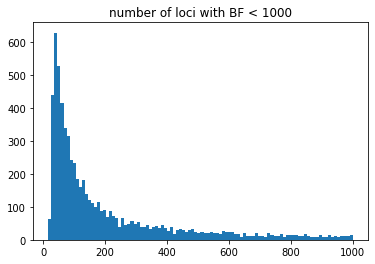



Eref 11532
	number of loci with meanBF >= 0 :  11532 (True)
	number of loci with meanBF >= 10 :  11532
	number of loci with meanBF >= 15 :  11532
	number of loci with meanBF >= 20 :  11532
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (16539) vs 1% (11532) (diff = 5007)
	not all SNPs with BF >= 20 are consistently in top 1% : full (15282) vs 1% (11532) (diff = 3750)


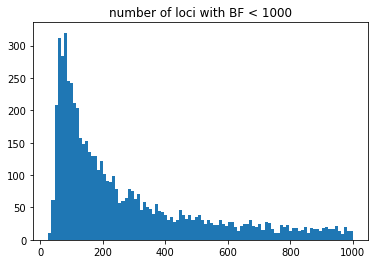



EMT 11305
	number of loci with meanBF >= 0 :  11305 (True)
	number of loci with meanBF >= 10 :  11305
	number of loci with meanBF >= 15 :  11305
	number of loci with meanBF >= 20 :  11305
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (16844) vs 1% (11305) (diff = 5539)
	not all SNPs with BF >= 20 are consistently in top 1% : full (15252) vs 1% (11305) (diff = 3947)


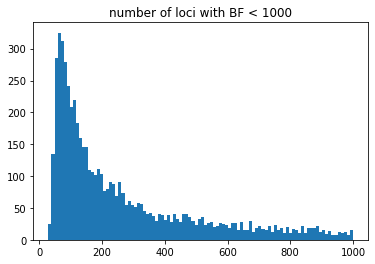



FFP 10982
	number of loci with meanBF >= 0 :  10982 (True)
	number of loci with meanBF >= 10 :  10966
	number of loci with meanBF >= 15 :  10518
	number of loci with meanBF >= 20 :  9746
	fraction of BF >= 15 :  0.96
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (10935) vs 1% (10518) (diff = 417)
	not all SNPs with BF >= 20 are consistently in top 1% : full (9875) vs 1% (9746) (diff = 129)


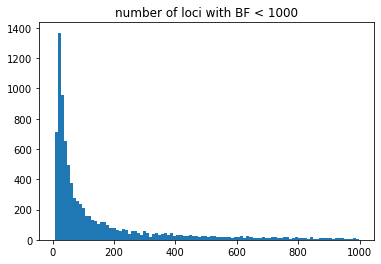



MWMT 10789
	number of loci with meanBF >= 0 :  10789 (True)
	number of loci with meanBF >= 10 :  10533
	number of loci with meanBF >= 15 :  9474
	number of loci with meanBF >= 20 :  8540
	fraction of BF >= 15 :  0.88
	fraction of BF >= 10 :  0.98
	not all SNPs with BF >= 15 are consistently in top 1% : full (9594) vs 1% (9474) (diff = 120)
	not all SNPs with BF >= 20 are consistently in top 1% : full (8588) vs 1% (8540) (diff = 48)


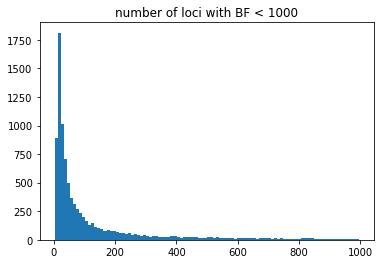



MAT 11588
	number of loci with meanBF >= 0 :  11588 (True)
	number of loci with meanBF >= 10 :  11588
	number of loci with meanBF >= 15 :  11588
	number of loci with meanBF >= 20 :  11588
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (20980) vs 1% (11588) (diff = 9392)
	not all SNPs with BF >= 20 are consistently in top 1% : full (19277) vs 1% (11588) (diff = 7689)


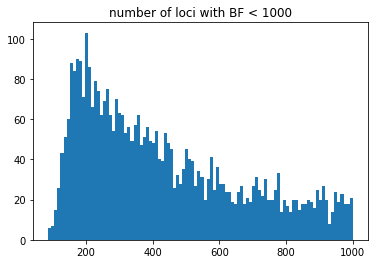



SHM 8780
	number of loci with meanBF >= 0 :  8780 (True)
	number of loci with meanBF >= 10 :  3071
	number of loci with meanBF >= 15 :  2172
	number of loci with meanBF >= 20 :  1706
	fraction of BF >= 15 :  0.25
	fraction of BF >= 10 :  0.35
	not all SNPs with BF >= 15 are consistently in top 1% : full (2173) vs 1% (2172) (diff = 1)


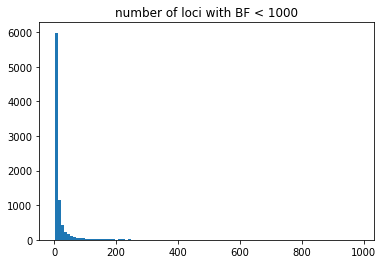



MSP 9968
	number of loci with meanBF >= 0 :  9968 (True)
	number of loci with meanBF >= 10 :  9329
	number of loci with meanBF >= 15 :  7725
	number of loci with meanBF >= 20 :  6612
	fraction of BF >= 15 :  0.77
	fraction of BF >= 10 :  0.94
	not all SNPs with BF >= 15 are consistently in top 1% : full (7832) vs 1% (7725) (diff = 107)
	not all SNPs with BF >= 20 are consistently in top 1% : full (6645) vs 1% (6612) (diff = 33)


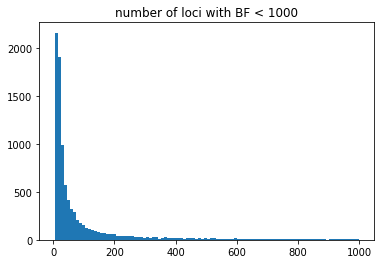



eFFP 11053
	number of loci with meanBF >= 0 :  11053 (True)
	number of loci with meanBF >= 10 :  11053
	number of loci with meanBF >= 15 :  11051
	number of loci with meanBF >= 20 :  11013
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (13655) vs 1% (11051) (diff = 2604)
	not all SNPs with BF >= 20 are consistently in top 1% : full (12253) vs 1% (11013) (diff = 1240)


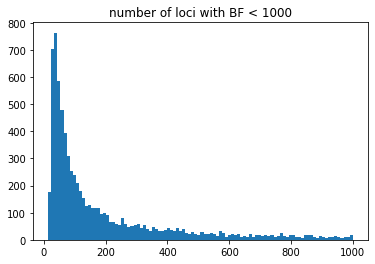



bFFP 9961
	number of loci with meanBF >= 0 :  9961 (True)
	number of loci with meanBF >= 10 :  5588
	number of loci with meanBF >= 15 :  4490
	number of loci with meanBF >= 20 :  3842
	fraction of BF >= 15 :  0.45
	fraction of BF >= 10 :  0.56
	not all SNPs with BF >= 15 are consistently in top 1% : full (4491) vs 1% (4490) (diff = 1)


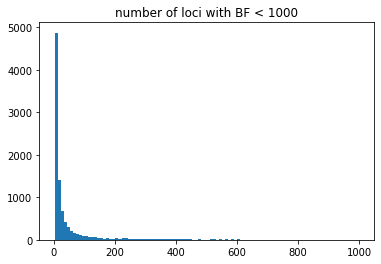



PAS 10293
	number of loci with meanBF >= 0 :  10293 (True)
	number of loci with meanBF >= 10 :  10201
	number of loci with meanBF >= 15 :  8977
	number of loci with meanBF >= 20 :  7643
	fraction of BF >= 15 :  0.87
	fraction of BF >= 10 :  0.99
	not all SNPs with BF >= 15 are consistently in top 1% : full (9294) vs 1% (8977) (diff = 317)
	not all SNPs with BF >= 20 are consistently in top 1% : full (7732) vs 1% (7643) (diff = 89)


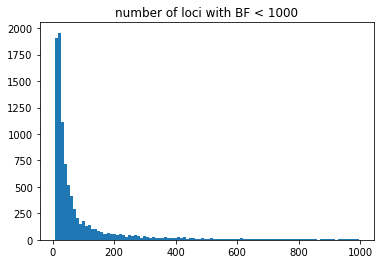



DD_0 11478
	number of loci with meanBF >= 0 :  11478 (True)
	number of loci with meanBF >= 10 :  11478
	number of loci with meanBF >= 15 :  11478
	number of loci with meanBF >= 20 :  11478
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (20797) vs 1% (11478) (diff = 9319)
	not all SNPs with BF >= 20 are consistently in top 1% : full (18929) vs 1% (11478) (diff = 7451)


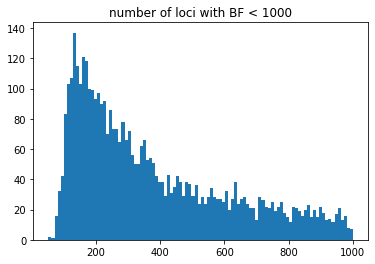



CMD 9060
	number of loci with meanBF >= 0 :  9060 (True)
	number of loci with meanBF >= 10 :  3707
	number of loci with meanBF >= 15 :  2701
	number of loci with meanBF >= 20 :  2144
	fraction of BF >= 15 :  0.3
	fraction of BF >= 10 :  0.41


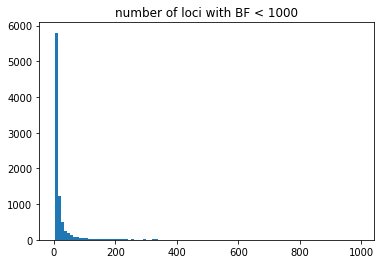



NFFD 9653
	number of loci with meanBF >= 0 :  9653 (True)
	number of loci with meanBF >= 10 :  4327
	number of loci with meanBF >= 15 :  3389
	number of loci with meanBF >= 20 :  2814
	fraction of BF >= 15 :  0.35
	fraction of BF >= 10 :  0.45


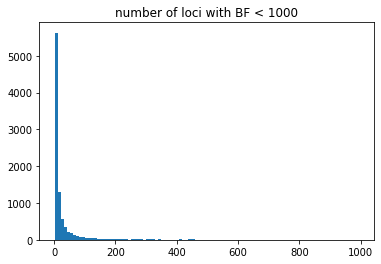



EXT 8176
	number of loci with meanBF >= 0 :  8176 (True)
	number of loci with meanBF >= 10 :  1519
	number of loci with meanBF >= 15 :  1067
	number of loci with meanBF >= 20 :  857
	fraction of BF >= 15 :  0.13
	fraction of BF >= 10 :  0.19


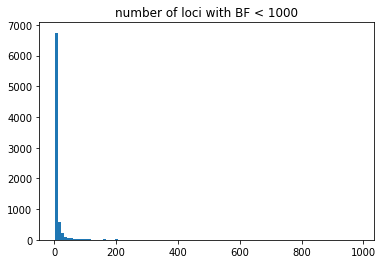



DD5 11418
	number of loci with meanBF >= 0 :  11418 (True)
	number of loci with meanBF >= 10 :  11418
	number of loci with meanBF >= 15 :  11418
	number of loci with meanBF >= 20 :  11418
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (15726) vs 1% (11418) (diff = 4308)
	not all SNPs with BF >= 20 are consistently in top 1% : full (14488) vs 1% (11418) (diff = 3070)


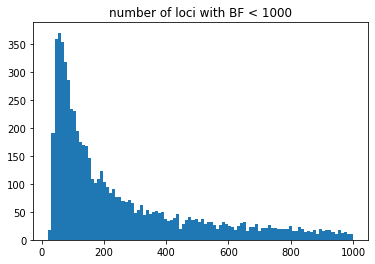



AHM 9106
	number of loci with meanBF >= 0 :  9106 (True)
	number of loci with meanBF >= 10 :  4315
	number of loci with meanBF >= 15 :  3135
	number of loci with meanBF >= 20 :  2537
	fraction of BF >= 15 :  0.34
	fraction of BF >= 10 :  0.47


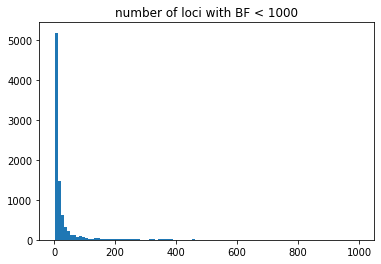



MCMT 11526
	number of loci with meanBF >= 0 :  11526 (True)
	number of loci with meanBF >= 10 :  11526
	number of loci with meanBF >= 15 :  11526
	number of loci with meanBF >= 20 :  11526
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (22391) vs 1% (11526) (diff = 10865)
	not all SNPs with BF >= 20 are consistently in top 1% : full (20323) vs 1% (11526) (diff = 8797)


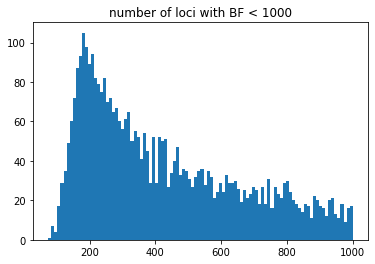



MAP 10906
	number of loci with meanBF >= 0 :  10906 (True)
	number of loci with meanBF >= 10 :  10906
	number of loci with meanBF >= 15 :  10906
	number of loci with meanBF >= 20 :  10906
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (21048) vs 1% (10906) (diff = 10142)
	not all SNPs with BF >= 20 are consistently in top 1% : full (18459) vs 1% (10906) (diff = 7553)


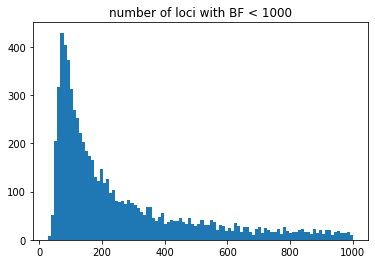




Fraction of meanBF >=15 across envs


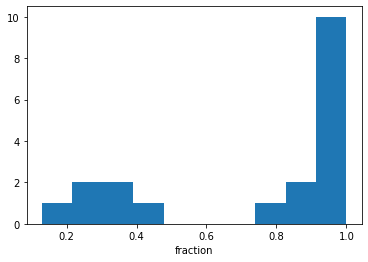

,TD,Eref,EMT,FFP,MWMT,MAT,SHM,MSP,eFFP,bFFP,PAS,DD_0,CMD,NFFD,EXT,DD5,AHM,MCMT,MAP
0,1.0,1.0,1.0,0.96,0.88,1.0,0.25,0.77,1.0,0.45,0.87,1.0,0.3,0.35,0.13,1.0,0.34,1.0,1.0


In [108]:
# for **ONLY** those loci that are consistently ranked in top 1%
# print histograms of bayes factor for each environment for BFs < 100
# print fraction of top 1%BFs that have BF ≥ 15 or BF ≥ 20

# also count number of loci across all SNPs that have BF ≥ 15 or BF ≥ 20, print if count doesn't match top 1%
fracs = defaultdict(dict)
for env,df in envdfs.items():
    # reduce loci to only the loci consistently ranked in top 1%
    df = df[df['rank_consistency_top1perc_for-gte3chains'] == True]
    BFs = df['mean_BF']
    small15 = sum(BFs >= 15)
    small20 = sum(BFs >= 20)
    print(ColorText(env).bold(), nrow(df))
    print('\tnumber of loci with meanBF >= 0 : ', sum(BFs >= 0), "(%s)" % str(sum(BFs >= 0) == nrow(df)))
    print('\tnumber of loci with meanBF >= 10 : ', sum(BFs >= 10))
    print('\tnumber of loci with meanBF >= 15 : ', small15)
    print('\tnumber of loci with meanBF >= 20 : ', small20)
    frac = round(sum(BFs >= 15)/nrow(df), 2)
    frac2 = round(sum(BFs >= 10)/nrow(df), 2)
    fracs[env][0] = frac
    print('\tfraction of BF >= 15 : ', frac)
    print('\tfraction of BF >= 10 : ', frac2)
    sum15 = sum(envdfs[env]['mean_BF'] >= 15)
    sum20 = sum(envdfs[env]['mean_BF'] >= 20)
    if small15 != sum15:
        text = '\tnot all SNPs with BF >= 15 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum15}) vs 1% ({small15}) (diff = {sum15 - small15})").warn().bold())
    if small20 != sum20:
        text = '\tnot all SNPs with BF >= 20 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum20}) vs 1% ({small20}) (diff = {sum20 - small20})").warn().bold())
    plt.hist(BFs[BFs<1000], bins=100)
    plt.title('number of loci with BF < 1000')
    plt.show()
    print('\n')

# create histogram for fraction of SNPs in consistent top 1% across environments
print(ColorText('\nFraction of meanBF >=15 across envs').bold())
fracdf = pd.DataFrame(fracs)
plt.hist(fracdf.loc[0,:])
plt.xlabel('fraction')
plt.show()
fracdf

In [103]:
df[df['rank_mean_BF']==1]

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Scaffold_15807-67183,9,315,-0.416695,0.060537,151.018797,-0.056995,0.008421,10.88419,MAP,9,315,-0.416176,0.06147,118.809797,-0.057002,0.008523,10.644513,MAP,9,315,-0.415639,0.061812,131.284306,-0.056897,0.008557,10.53054,MAP,9,315,-0.415939,0.060572,121.229027,-0.057009,0.008364,11.029417,MAP,9,315,-0.415951,0.061437,119.380301,-0.056893,0.008492,10.681028,MAP,1,5,1,2,4,6.830375e+12,1,True,True,True


In [107]:
df2 = envdfs['MAT'][envdfs['MAT']['rank_consistency_top1perc_for-gte3chains'] == True]
sum(df2['mean_BF'] >= 15)

11588

In [106]:
df2.head()

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Scaffold_12-706789,17,1047,-0.287005,0.091887,59.311040,-0.025323,0.007736,2.973453,TD,17,1047,-0.289733,0.092281,37.300364,-0.025580,0.007812,2.975452,TD,17,1047,-0.289234,0.092343,34.912187,-0.025550,0.007823,2.962445,TD,17,1047,-0.289948,0.092225,42.805234,-0.025577,0.007780,2.995470,TD,17,1047,-0.288904,0.091539,33.913249,-0.025534,0.007743,3.010722,TD,981,3090,3454,2381,3662,14616.435680,2449,True,True,True
Scaffold_12-706819,17,1050,0.282151,0.094445,33.850925,0.024286,0.007704,2.791021,TD,17,1050,0.281179,0.094997,30.312461,0.024285,0.007730,2.775041,TD,17,1050,0.281615,0.095279,29.200293,0.024269,0.007785,2.738593,TD,17,1050,0.283568,0.095598,37.862517,0.024405,0.007800,2.755885,TD,17,1050,0.283530,0.096126,34.910050,0.024469,0.007830,2.750096,TD,3686,4406,4646,2996,3472,2102.446420,3666,True,True,True
Scaffold_12-709159,17,1070,-0.311416,0.096220,45.358267,-0.026414,0.008001,3.016489,TD,17,1070,-0.312862,0.096643,45.209082,-0.026472,0.008003,3.026865,TD,17,1070,-0.313633,0.097533,40.370452,-0.026490,0.008047,3.001916,TD,17,1070,-0.313963,0.097545,53.979500,-0.026602,0.008077,3.004377,TD,17,1070,-0.314849,0.097919,44.530273,-0.026597,0.008063,3.012241,TD,2081,2080,2664,1348,2147,38810.700281,1992,True,True,True
Scaffold_12-709435,17,1073,-0.289497,0.103545,28.615204,-0.022854,0.008000,2.368417,TD,17,1073,-0.286827,0.106052,33.230199,-0.022650,0.008172,2.253416,TD,17,1073,-0.289554,0.105308,32.372748,-0.022855,0.008136,2.303873,TD,17,1073,-0.288770,0.104210,44.569894,-0.022773,0.008044,2.333741,TD,17,1073,-0.287368,0.105086,35.807280,-0.022715,0.008093,2.300820,TD,4862,3757,3925,2186,3330,3103.891429,3394,True,True,True
Scaffold_14-16470,17,1086,0.253718,0.116165,15.315043,0.014899,0.006938,1.498104,TD,17,1086,0.254256,0.116409,21.369217,0.014954,0.006951,1.502245,TD,17,1086,0.254027,0.116131,13.942822,0.014927,0.006922,1.507905,TD,17,1086,0.253713,0.118035,24.262128,0.014938,0.007080,1.457607,TD,17,1086,0.250180,0.115507,12.130991,0.014719,0.006862,1.495393,TD,11818,7575,13270,6261,15520,55.005234,9413,True,True,True
